In [135]:
import pandas as pd
import numpy as np 
import requests
import time
from datetime import datetime
from dateutil.relativedelta import relativedelta
import matplotlib.dates as mdates
import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker
import matplotlib.transforms as mtransforms
import seaborn as sns
sns.set()

In [149]:
def ma_chart(fx,tech,title,short_leg,long_leg,start_date):

    print('Measure for buy/sell signal, resistance levels')
    
    data = raw_data.copy()

    if tech == 'SMA':
        short = data.rolling(window = short_leg).mean()
        long = data.rolling(window = long_leg).mean()
        indicator = (short[fx]/long[fx]).loc[start_date:]

    elif tech == 'EMA':
        short = data.ewm(span = short_leg, adjust = False).mean()
        long = data.ewm(span = long_leg, adjust = False).mean()
        indicator = (short[fx]/long[fx]).loc[start_date:]

    if fx in ['EUR','GBP','AUD','NZD']: colormap='RdYlGn_r' 
    else: colormap='RdYlGn'

    if fx in ['EUR','GBP','AUD','NZD']: 
        if indicator.iloc[-1].item()>(1+indicator.std()): signal = 'Short'
        elif indicator.iloc[-1].item()<(1-indicator.std()): signal = 'Long'
        elif indicator.iloc[-1].item()>(1+indicator.std()*0.5): signal = 'Slightly Short'
        elif indicator.iloc[-1].item()<(1-indicator.std()*0.5): signal = 'Slightly Long'
        else: signal = 'Market Neutral'
    else:
        if indicator.iloc[-1].item()>(1+indicator.std()): signal = 'Long'
        elif indicator.iloc[-1].item()<(1-indicator.std()): signal = 'Short'
        elif indicator.iloc[-1].item()>(1+indicator.std()*0.5): signal = 'Slighly Long'
        elif indicator.iloc[-1].item()<(1-indicator.std()*0.5): signal = 'Slighly Short'
        else: signal = 'Market Neutral'

    print(f"{fx} signal is {signal}")

    #fig = plt.figure(figsize = (8,5.25))
    #ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan = 2)
    #ax2 = plt.subplot2grid((3, 1), (2, 0), rowspan = 1)

    fig = plt.figure(figsize = (8,10.25))
    ax1 = plt.subplot2grid((3, 1), (0, 0))
    ax2 = plt.subplot2grid((3, 1), (1, 0))

    ax1.scatter(x=data.loc[start_date:].index,y=data[fx].loc[start_date:],c=indicator,cmap=colormap,s=5,edgecolors='gray', linewidths=0.2)
    ax1.plot(short.loc[start_date:, :].index, short[fx].loc[start_date:],
        label = f"{short_leg}d", linewidth = 0.5, color = 'black')
    ax1.plot(long.loc[start_date:, :].index, long[fx].loc[start_date:],
        label = f"{long_leg}d", linestyle = '--', linewidth = 0.5, color = 'black')
    ax2.plot(indicator.loc[start_date:].index, indicator.loc[start_date:],
        label = f"{short_leg}d/{long_leg}d", linewidth = 0.75, color = 'navy')
    ax2.axhline(y=1, color='black', linestyle='--', linewidth=0.5)
    #ax2.axhline(y=1+indicator.std(), color='black', linestyle='--', linewidth=0.5)
    #ax2.axhline(y=1-indicator.std(), color='black', linestyle='--', linewidth=0.5)
    ax2.fill_between(indicator.loc[start_date:].index, 1-indicator.std(), 1+indicator.std(), color='b', alpha=0.15)


    ax1.set_title(f"{title} {short_leg}d/{long_leg}d")
    ax1.legend(loc = 'best')
    ax1.set_ylabel('FX Rate')
    ax1.set_xticklabels([])
    ax2.legend(loc = 'best')
    ax1.margins(x=0)
    ax2.margins(x=0)


In [150]:
def macd_chart(fx,title,short_leg,long_leg,signal_leg,start_date):

    print('Measure for momentum, new trends (line cross)')

    data = raw_data.copy()
    #data.index = data.index.strftime('%Y-%m-%d')

    short = data.ewm(span = short_leg, adjust = False).mean()
    long = data.ewm(span = long_leg, adjust = False).mean()
    MACD = short[fx]-long[fx]
    EMA = MACD.ewm(span = signal_leg, adjust = False).mean()
    Forest = (MACD-EMA).loc[start_date:]

    fig = plt.figure(figsize = (8,10.25))
    ax1 = plt.subplot2grid((3, 1), (0, 0))
    ax2 = plt.subplot2grid((3, 1), (1, 0))

    if fx in ['EUR','GBP','AUD','NZD']: colormap='RdYlGn_r' 
    else: colormap='RdYlGn'

    if fx in ['EUR','GBP','AUD','NZD']: 
        if Forest.iloc[-1].item()>(Forest.std()): signal = 'Favorable'
        elif Forest.iloc[-1].item()<(Forest.std()): signal = 'Unavorable'
        elif Forest.iloc[-1].item()>(Forest.std()): signal = 'Slightly Favorable'
        elif Forest.iloc[-1].item()<(Forest.std()): signal = 'Slightly Unavorable'
        else: signal = 'Market Neutral'
    else:
        if Forest.iloc[-1].item()>(Forest.std()): signal = 'Unavorable'
        elif Forest.iloc[-1].item()<(Forest.std()): signal = 'Favorable'
        elif Forest.iloc[-1].item()>(Forest.std()): signal = 'Slighly Unfavorable'
        elif Forest.iloc[-1].item()<(Forest.std()): signal = 'Slighly Favorable'
        else: signal = 'Market Neutral'

    print(f"{fx} is {signal}")
    
    ax1.scatter(x=data.loc[start_date:].index,y=data[fx].loc[start_date:],c=Forest,cmap=colormap,s=20,edgecolors='gray', linewidths=0.2)
    ax2.bar(Forest.loc[start_date:].index, Forest.loc[start_date:],
        label = f"MACD-EMA", color = 'lightblue', edgecolor='gray', linewidth=0.2)
    ax2.plot(MACD.loc[start_date:].index, MACD.loc[start_date:],
        label = f"MACD {short_leg}-{long_leg}", linewidth = 0.75, color = 'red')
    ax2.plot(EMA.loc[start_date:].index, EMA.loc[start_date:],
        label = f"EMA {short_leg}-{long_leg}", linewidth = 0.75, color = 'black')
    ax2.axhline(y=0, color='black', linestyle='--', linewidth=0.5)

    ax1.set_title(f"{title} {short_leg}d/{long_leg}d/{signal_leg}d")
    ax1.set_ylabel('FX Rate')
    ax1.set_xticklabels([])
    ax2.legend(loc = 'best')
    ax1.xaxis.set_major_locator(mdates.MonthLocator())
    ax2.xaxis.set_major_locator(mdates.MonthLocator())
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax1.margins(x=0)
    ax2.margins(x=0)
    

In [151]:
def bollinger_chart(fx,title,bollinger_window,sigma_count,start_date):

    print('Measure for oversold, overbought and volatility')
    
    data = raw_data.copy()
    #data.index = data.index.strftime('%Y-%m-%d')

    # Generate Bollinger Bands
    bollinger_mean = data.rolling(window = bollinger_window).mean()
    bollinger_sigma = data.rolling(window = bollinger_window).std()
    bollinger_zscore = (data-bollinger_mean)/bollinger_sigma
    bollinger_high = bollinger_mean + (bollinger_sigma * sigma_count)
    bollinger_low = bollinger_mean - (bollinger_sigma * sigma_count)

    bollinger_buy = data - bollinger_high
    bollinger_buy = bollinger_buy.apply(np.sign)
    bollinger_buy = bollinger_buy.replace(-1, 0)
    bollinger_sell = data - bollinger_low
    bollinger_sell = bollinger_sell.apply(np.sign)
    bollinger_sell = bollinger_sell.replace(1, 0)
    indicator = (bollinger_buy + bollinger_sell)[fx].loc[start_date:]
    
    #fig = plt.figure(figsize = (8,5.25))
    #ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan = 2)
    #ax2 = plt.subplot2grid((3, 1), (2, 0), rowspan = 1)

    fig = plt.figure(figsize = (8,10.25))
    ax1 = plt.subplot2grid((3, 1), (0, 0))
    ax2 = plt.subplot2grid((3, 1), (1, 0))
  
    if fx in ['EUR','GBP','AUD','NZD']: colormap='RdYlGn_r' 
    else: colormap='RdYlGn'

    if fx in ['EUR','GBP','AUD','NZD']: 
        if bollinger_zscore[fx].iloc[-1].item()>sigma_count: signal = 'Overbought'
        elif bollinger_zscore[fx].iloc[-1].item()<-sigma_count: signal = 'Oversold'
        elif bollinger_zscore[fx].iloc[-1].item()>sigma_count*.5: signal = 'Slightly Overbought'
        elif bollinger_zscore[fx].iloc[-1].item()<-sigma_count*.5: signal = 'Slightly Oversold'
        else: signal = 'Market Neutral'
    else:
        if bollinger_zscore[fx].iloc[-1].item()>sigma_count: signal = 'Oversold'
        elif bollinger_zscore[fx].iloc[-1].item()<-sigma_count: signal = 'Overbought'
        elif bollinger_zscore[fx].iloc[-1].item()>sigma_count*.5: signal = 'Slightly Oversold'
        elif bollinger_zscore[fx].iloc[-1].item()<-sigma_count*.5: signal = 'Slightly Overbought'
        else: signal = 'Market Neutral'

    print(f"{fx} is {signal}")

    ax1.scatter(x=data.loc[start_date:].index,y=data[fx].loc[start_date:],c=indicator,cmap=colormap,s=20,edgecolors='gray', linewidths=0.2)
    ax1.plot(bollinger_mean.loc[start_date:, :].index, bollinger_mean[fx].loc[start_date:], 
        label = f"Mean_{bollinger_window}d", linewidth = 0.5, color = 'black')
    ax1.fill_between(bollinger_mean.loc[start_date:].index, bollinger_low[fx].loc[start_date:], bollinger_high[fx].loc[start_date:], color='b', alpha=0.15)

    ax2.plot(bollinger_zscore.loc[start_date:].index, bollinger_zscore[fx].loc[start_date:],
        label = f"Z-score", linewidth = 0.75, color = 'navy')
    ax2.axhline(y=0, color='black', linestyle='--', linewidth=0.5)
    ax2.fill_between(indicator.loc[start_date:].index, -sigma_count, sigma_count, color='b', alpha=0.15)
    
    ax1.set_title(f"{title} {bollinger_window}d with sigma={sigma_count}")
    ax1.set_ylabel('FX Rate')
    ax1.set_xticklabels([])
    ax2.legend(loc = 'best')
    ax2.xaxis.set_major_locator(mdates.MonthLocator())
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax1.margins(x=0)
    ax2.margins(x=0)


In [152]:
def rsi_chart(fx,title,days,start_date):

    print('Relative Strengrh Indicator: Measure for oversold, overbought')

    data = raw_data.copy()
    fx_temp = pd.DataFrame(data[fx])
    fx_temp['Change'] = pd.DataFrame(raw_data[fx]-raw_data[fx].shift(1))
    fx_temp['Positive'] = fx_temp['Change'][fx_temp['Change']>0].copy()
    fx_temp['Negative'] = fx_temp['Change'][fx_temp['Change']<=0].copy()
    fx_temp = fx_temp.fillna(0)
    fx_temp['Roll_Pos'] = fx_temp['Positive'].rolling(window=14).sum()/14
    fx_temp['Roll_Neg'] = fx_temp['Negative'].rolling(window=14).sum()/14
    fx_temp['RS'] = -fx_temp['Roll_Pos']/fx_temp['Roll_Neg']
    fx_temp['RSI'] = 100-(100/(1+fx_temp['RS']))

    indicator = fx_temp['RSI'].loc[start_date:]

    #fig = plt.figure(figsize = (8,5.25))
    #ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan = 2)
    #ax2 = plt.subplot2grid((3, 1), (2, 0), rowspan = 1)

    fig = plt.figure(figsize = (8,10.25))
    ax1 = plt.subplot2grid((3, 1), (0, 0))
    ax2 = plt.subplot2grid((3, 1), (1, 0))

    if fx in ['EUR','GBP','AUD','NZD']: colormap='RdYlGn_r' 
    else: colormap='RdYlGn'

    if fx in ['EUR','GBP','AUD','NZD']: 
        if indicator.iloc[-1].item()>70: signal = 'Overbought'
        elif indicator.iloc[-1].item()<30: signal = 'Oversold'
        elif indicator.iloc[-1].item()>60: signal = 'Slightly Overbought'
        elif indicator.iloc[-1].item()<40: signal = 'Slighly Oversold'
        else: signal = 'Market Neutral'
    else:
        if indicator.iloc[-1].item()>70: signal = 'Oversold'
        elif indicator.iloc[-1].item()<30: signal = 'Overbought'
        elif indicator.iloc[-1].item()>60: signal = 'Slighly Oversold'
        elif indicator.iloc[-1].item()<40: signal = 'Slighly Overbought'
        else: signal = 'Market Neutral'

    print(f"{fx} is {signal}")

    ax1.scatter(x=fx_temp.loc[start_date:].index,y=fx_temp[fx].loc[start_date:],c=indicator,cmap=colormap,s=20,edgecolors='gray', linewidths=0.2)
    ax2.plot(fx_temp.loc[start_date:].index, fx_temp['RSI'].loc[start_date:],
        label = f"RSI", linewidth = 0.75, color = 'navy')
    ax2.axhline(y=50, color='black', linestyle='--', linewidth=0.5)
    ax2.fill_between(indicator.loc[start_date:].index, 30, 70, color='b', alpha=0.15)


    ax1.set_title(f"{title} {days}d")
    ax1.set_ylabel('FX Rate')
    ax1.set_xticklabels([])
    ax2.legend(loc = 'best')
    ax2.xaxis.set_major_locator(mdates.MonthLocator())
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax1.margins(x=0)
    ax2.margins(x=0)

Measure for buy/sell signal, resistance levels
JPY signal is Slighly Short


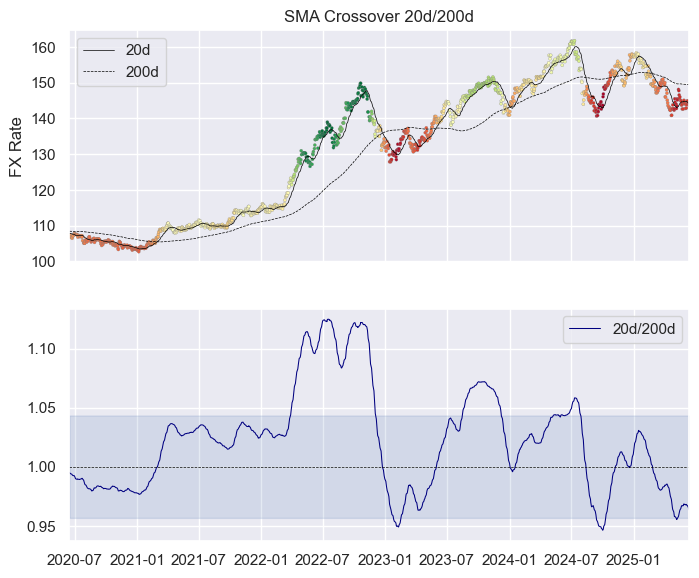

In [163]:
fx='JPY'

months60 = (raw_fred.index.max()-relativedelta(months=60)).strftime("%Y-%m-%d")
months12 =  (raw_fred.index.max()-relativedelta(months=12)).strftime("%Y-%m-%d")

ma_chart(fx,'SMA','SMA Crossover',20,200,months60)

Measure for buy/sell signal, resistance levels
JPY signal is Slighly Short


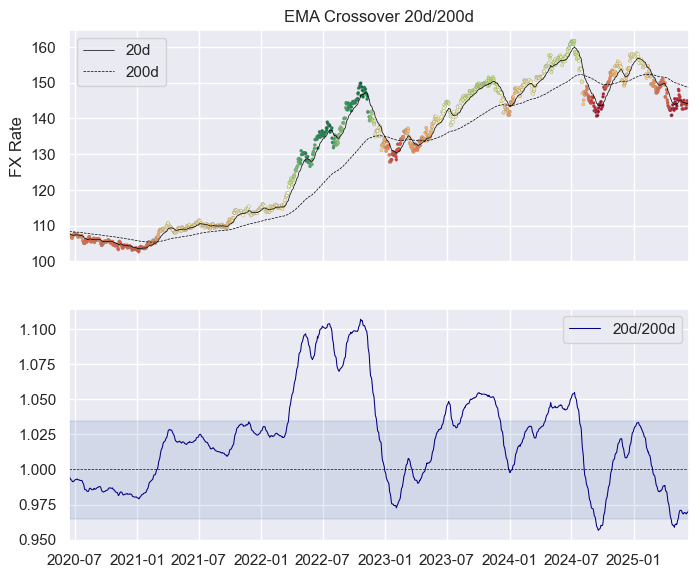

In [164]:
ma_chart(fx,'EMA','EMA Crossover',20,200,months60)

Measure for momentum, new trends (line cross)
JPY is Favorable


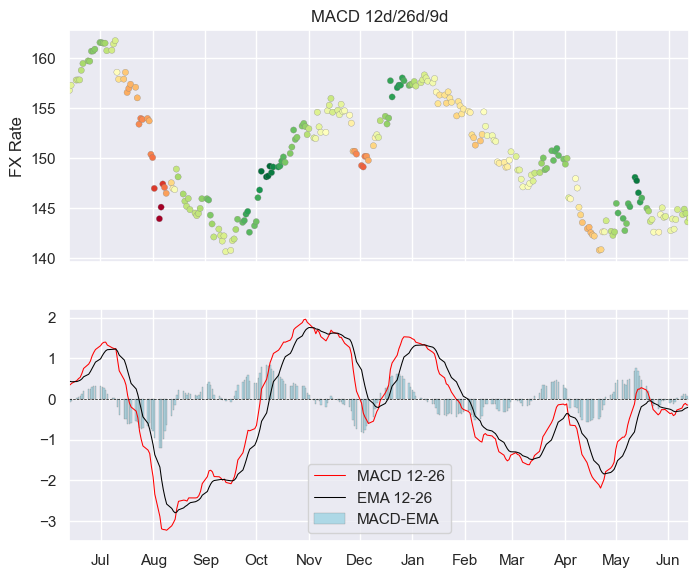

In [165]:
macd_chart(fx,'MACD',12,26,9,months12)

Measure for oversold, overbought and volatility
JPY is Market Neutral


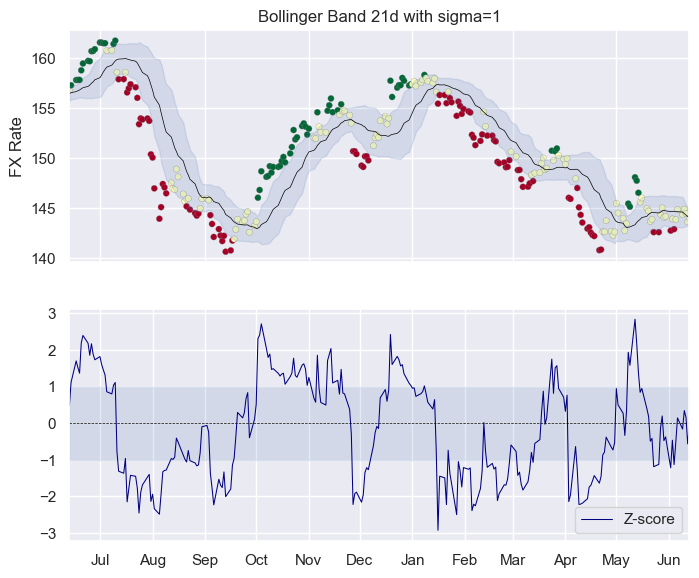

In [166]:
bollinger_chart(fx,'Bollinger Band',21,1,months12)

Relative Strengrh Indicator: Measure for oversold, overbought
JPY is Market Neutral


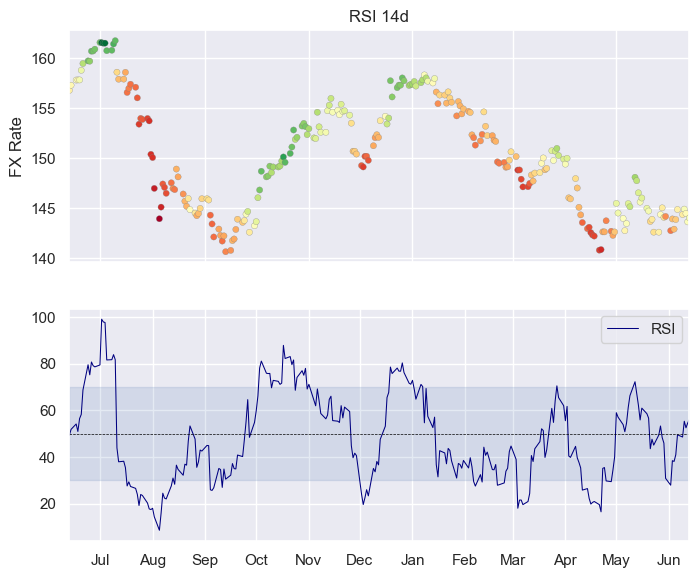

In [167]:
rsi_chart(fx,'RSI',14,months12)

(0.942368, 1.273776)

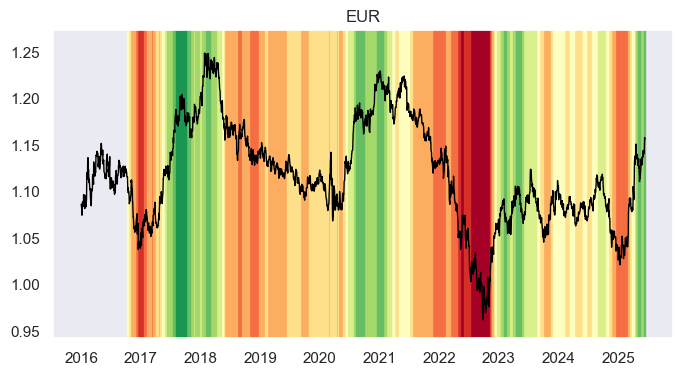

In [16]:
fx = 'EUR'

ma = pd.DataFrame(SMA_short[fx]/SMA_long[fx]).squeeze('columns')


min_val = ma.min()
max_val = ma.max()
num_bins = 10
bin_width = (max_val - min_val) / num_bins
bins = [min_val + i * bin_width for i in range(num_bins + 1)]

state = pd.cut(ma,bins=bins,include_lowest=True, labels=list(range(num_bins)))

cmap = plt.get_cmap('RdYlGn')
#data[fx].plot(color='black', linewidth=1.5, marker='', figsize=(8, 4))

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(data[fx].index,data[fx], color='black', linewidth=1, marker='')
#ax = plt.gca() 
ax.set_xlabel('')
ax.set_title(fx)
ax.grid(False)
#ax.legend(loc='upper center')
#ax.set_xlim(xmin=ma.index[0], xmax=ma.index[-1])

trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
transform = ax.get_xaxis_transform()

for i, color in enumerate(cmap(np.arange(0, 1, 1/(num_bins)).tolist())):
    ax.fill_between(data[fx].index,0,1, where=state==i,edgecolor=color,facecolor=color, transform=transform)

#ax.axhline(vix.mean(), linestyle='dashed', color='xkcd:dark grey',
# alpha=0.6, label='Full-period mean', marker='')

plt.ylim(data[fx].min()*0.98, data[fx].max()*1.02)